In [1]:
import numpy as np


np.random.seed(70103)

# Problem 2

## Part 1

In [2]:
def H(x: int, y: int, s: float = 1.0) -> float:
  norm = 1 / (np.pi * s**4)
  sq_sum = ((x**2 + y**2) / (2 * s**2))
  val = (1 - sq_sum) * np.exp(- sq_sum)
  
  return val * norm

In [3]:
# define grid for calculating the log_filter
grid = np.arange(-2, 3)
xx, yy = np.meshgrid(grid, grid)
log_filter = np.vectorize(H)(xx, yy)

print(log_filter.round(3))


[[-0.017 -0.039 -0.043 -0.039 -0.017]
 [-0.039  0.     0.097  0.    -0.039]
 [-0.043  0.097  0.318  0.097 -0.043]
 [-0.039  0.     0.097  0.    -0.039]
 [-0.017 -0.039 -0.043 -0.039 -0.017]]


## Part 3

In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

In [5]:
BATCH_SIZE = 100
EPOCHS = 5
LEARNING_RATE = 0.001
NUM_CLASSES = 2  # two classes: cats and dogs

In [6]:
test_dir = './dataset/test_set/'
train_dir = './dataset/training_set/'

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),  # transform picture to tensor
     transforms.Resize((28, 28)),  # 28 by 28 pixels
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # normalize a tensor image
)

In [8]:
train_folder = ImageFolder(root=train_dir, transform=transform)
test_folder = ImageFolder(root=test_dir, transform=transform)
# divide the dataset into batches
train_loader = DataLoader(train_folder, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_folder, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
# Convolutional neural network (two convolutional layers)
class UDA_CNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(UDA_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(
                    in_channels = 3,  # RGB images, so we need 3 channels
                    out_channels = 16,
                    kernel_size=5,
                    stride=1,
                    padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels = 16, # output from layer 1 is 16
                out_channels = 96, 
                kernel_size=5, 
                stride=1, 
                padding=2),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*96, num_classes)
        
    def forward(self, x):
        # Layer 1: 
        # input: 100 images, 28 * 28 pixels
        # output: 100 images 16 batches, 14 * 14
        out = self.layer1(x) 
        # Layer 2: 
        # input: 100 images, 16 batches, 14 * 14 
        # output: 100 images, 96 batches, 7 * 7
        out = self.layer2(out)
        # Rashape: 
        # output: 100 images, 96 *7*7 
        out = out.reshape(out.size(0), -1)
        # Rashape: 
        # output: 100 images, 2 classes probabilities 

        return self.fc(out)
      
model = UDA_CNN()

In [10]:
# Loss function
criterion = nn.CrossEntropyLoss()
# optimizer to update network parameters
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

epoch_loss = []
# Train the model
total_step = len(train_loader)
for epoch in range(EPOCHS):
    epoch_losses = []  # collect loss of every iteration
    for i, (images, labels) in enumerate(train_loader):
        images = images
        labels = labels

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    epoch_average_loss = np.mean(epoch_losses)
    epoch_loss.append(epoch_average_loss)
    print(
        'Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
            epoch + 1, EPOCHS, i + 1, total_step, epoch_average_loss
        )
    )

/Users/ljoana/.pyenv/versions/3.9.17/envs/latest-vdk-39/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/5], Step [80/80], Loss: 0.7390
Epoch [2/5], Step [80/80], Loss: 0.5715
Epoch [3/5], Step [80/80], Loss: 0.5304
Epoch [4/5], Step [80/80], Loss: 0.4892
Epoch [5/5], Step [80/80], Loss: 0.4502


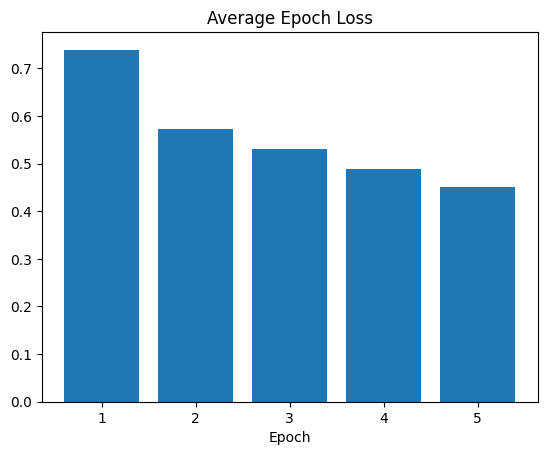

In [11]:
plt.bar(np.arange(len(epoch_loss)) + 1, epoch_loss)
plt.xlabel("Epoch")
plt.title("Average Epoch Loss")
plt.show()

# Problem 3

## Part 3

In [12]:
import matplotlib.pyplot as plt
from skimage import io, color, filters, feature

def apply_log(image, sigma=1.0):
    smoothed = filters.gaussian(image, sigma=sigma)  # Gaussian smoothing
    
    return filters.laplace(smoothed)  # Laplacian

def load_convert_to_grayscale(image_path: str):
    image = io.imread(image_path)
    
    return color.rgb2gray(image)

def display_results(gray_image, log_result, log_sigma, canny_result, canny_sigma):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(gray_image, cmap=plt.cm.gray)
    axes[0].set_title('Original Image')
    axes[1].imshow(log_result, cmap=plt.cm.gray)
    axes[1].set_title(f'LoG sigma={log_sigma}')
    axes[2].imshow(canny_result, cmap=plt.cm.gray)
    axes[2].set_title(f'Canny sigma={canny_sigma}')

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

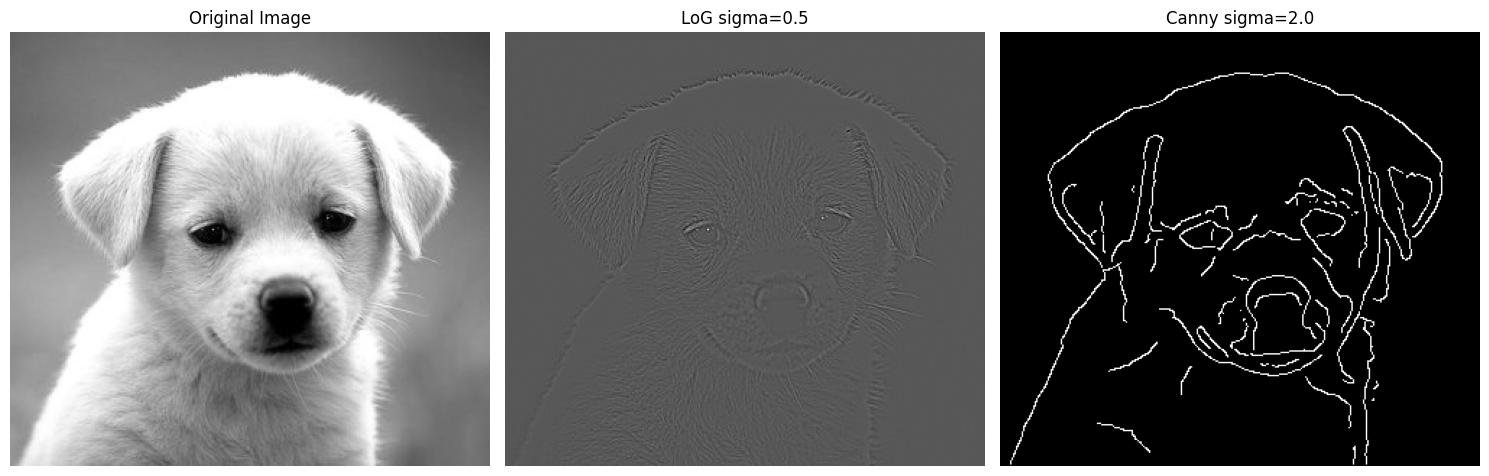

In [13]:
gray_image = load_convert_to_grayscale(image_path="dog.jpg")
log_result = apply_log(gray_image, sigma=0.5)
canny_result = feature.canny(gray_image, sigma=2.0)
display_results(gray_image, log_result, 0.5, canny_result, 2.0)

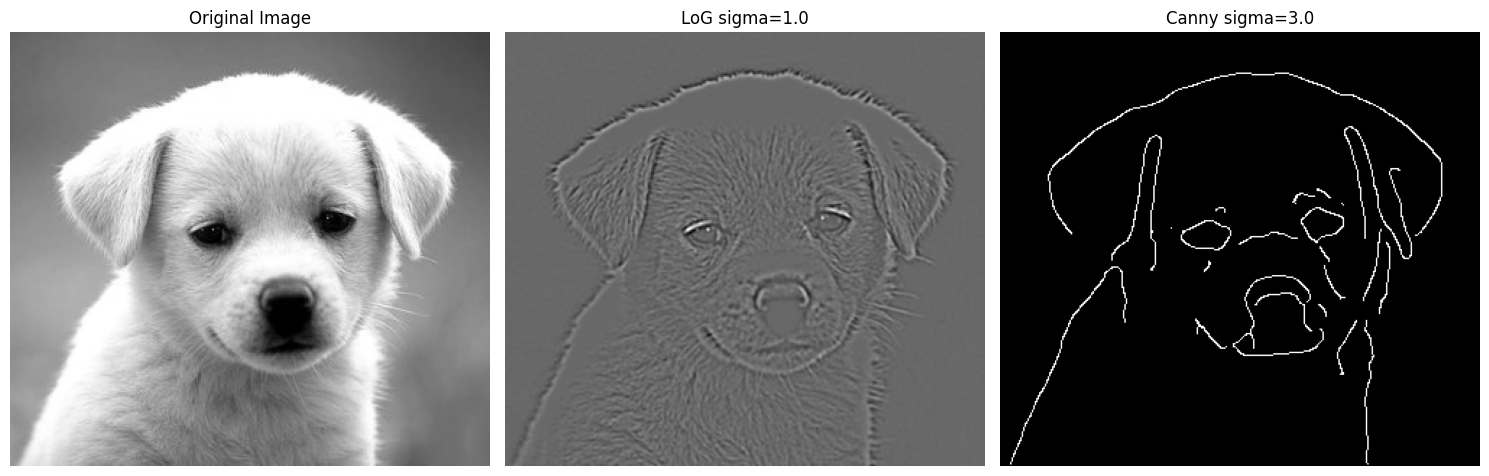

In [14]:
gray_image = load_convert_to_grayscale(image_path="dog.jpg")
log_result = apply_log(gray_image, sigma=1.0)
canny_result = feature.canny(gray_image, sigma=3.0)
display_results(gray_image, log_result, 1.0, canny_result, 3.0)

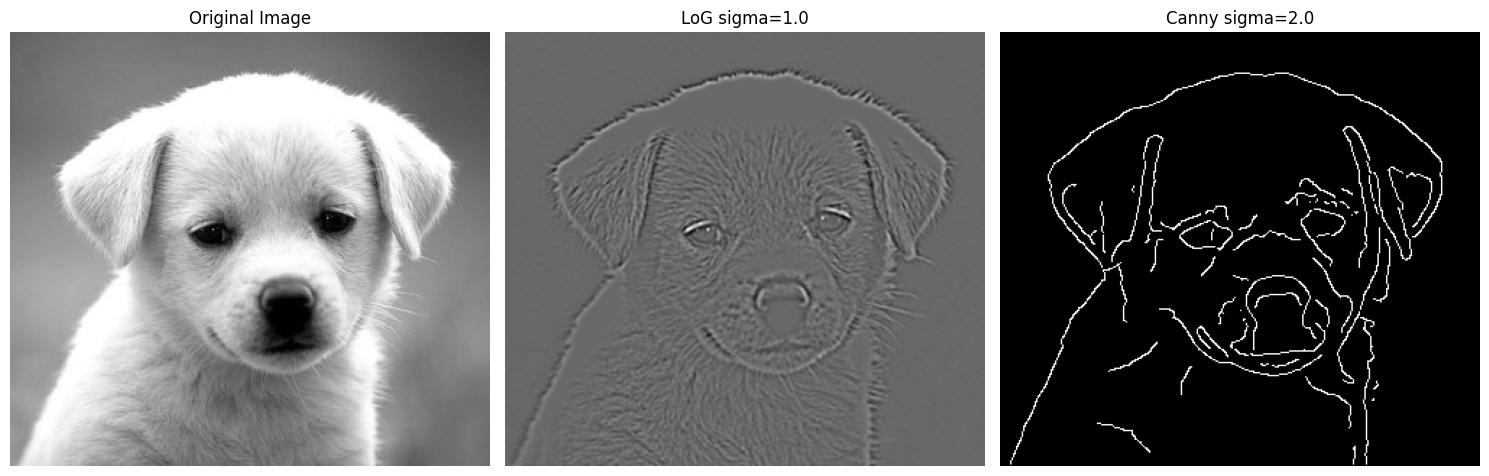

In [15]:
gray_image = load_convert_to_grayscale(image_path="dog.jpg")
log_result = apply_log(gray_image, sigma=1.0)
canny_result = feature.canny(gray_image, sigma=2.0)
display_results(gray_image, log_result, 1.0, canny_result, 2.0)

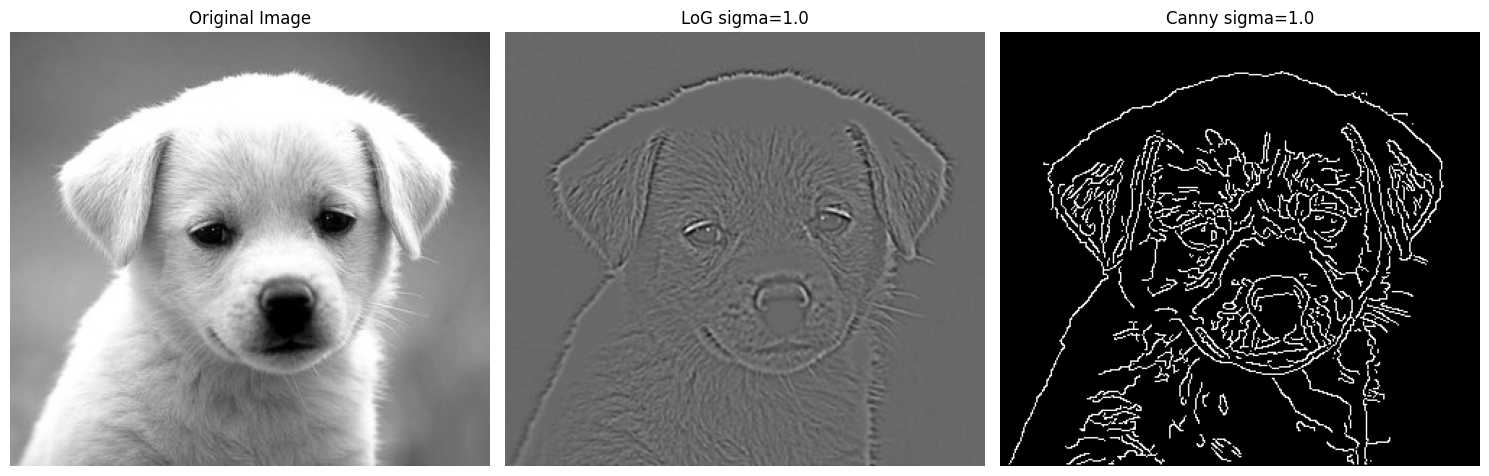

In [16]:
gray_image = load_convert_to_grayscale(image_path="dog.jpg")
log_result = apply_log(gray_image, sigma=1.0)
canny_result = feature.canny(gray_image, sigma=1.0)
display_results(gray_image, log_result, 1.0,  canny_result, 1.0)

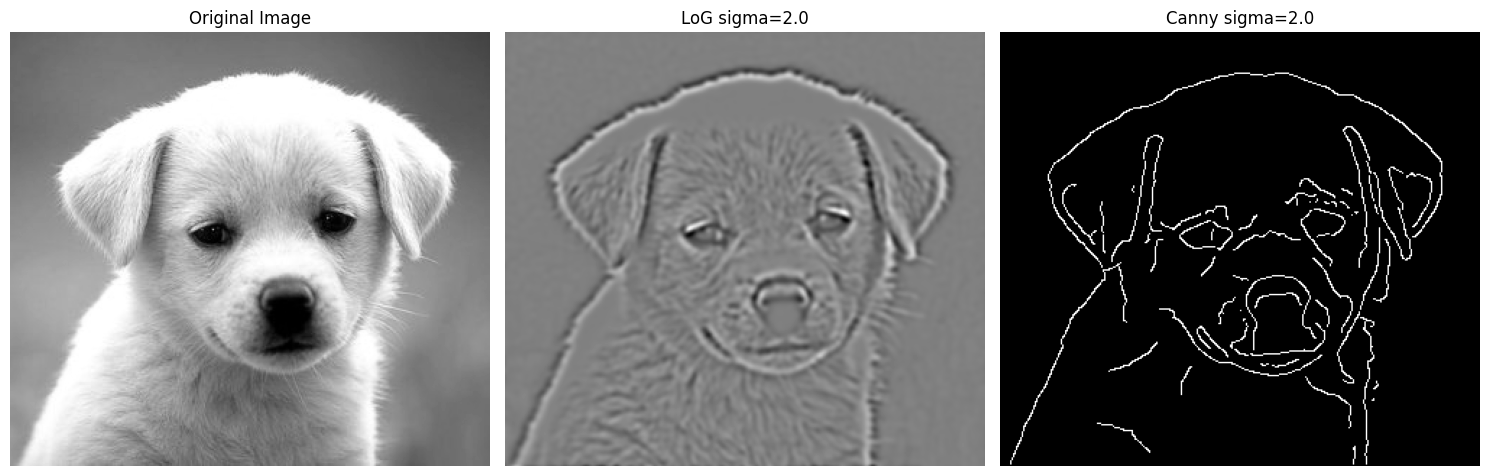

In [17]:
gray_image = load_convert_to_grayscale(image_path="dog.jpg")
log_result = apply_log(gray_image, sigma=2.0)
canny_result = feature.canny(gray_image, sigma=2)
display_results(gray_image, log_result, 2.0, canny_result, 2.0)